In [1]:
# Use the processed results and compute the plots from the paper
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
cwd = os.getcwd()
drive_path = cwd + '\\..\\' 
indiv_folder = 'full_results' # folder name for the results files
saving = False

In [2]:
# mount drive and set directory information
os.listdir(drive_path)
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='k'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='k'
plt.rcParams['ytick.color']='k'

# color scheme
black = 'k'
grey = '#b7b6b6' 
dark_grey = '#838281'
purple_as = '#bf32e7'
purple = '#f69cf4'
lblue = '#5ac5ff'
blue = '#0091ea'
green = '#00c853'
orange = '#ffab00'
red = '#ff3d00'

# settings
lw1 = 2
plt_txt = 10
plt_width = 3.4
plt_third_width = 2.3
plt_double_width = 7
plt_height = 3.5
fig_size_default = [plt_width, plt_height] # width then height in inches

# labels
lab_met_2min = 'Fast-Estimated Respirometry'
lab_met_avg = 'Steady-State Respirometry'
lab_hr = 'Heart Rate Model'
lab_dd = 'Data-Driven Model'
lab_dd_subj = 'Subject-Specific Data-Driven Model'
lab_osim = 'Musculoskeletal Model'
lab_met_bb = 'Per-Breath Respirometry'
lab_resp = 'Respirometry'
lab_hr_ind = 'Heart rate 2 min. estimate'
lab_met_fo = 'Fast-Estimated Respirometry'
lab_hr_fo = 'Heart rate first order fit'
lab_hybrid = 'Hybrid model'
# bar plot styles
bar_width = 0.2
bar_init_offset = 0.1
bar_width_ind = 2*bar_width
bar_spacing = 0.08
axes_spacing_bottom = -0.02
axes_spacing_left = 0.01

# error bar settings
err_capsize=3
err_lw = 1.5

# updating plot params
plt.rcParams.update({'font.size': plt_txt})
def_marker_size = 7
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

def update_prop(handle, orig):
  handle.update_from(orig)
  handle.set_marker("s")
  handle.set_markersize(def_marker_size)
plt.rcParams['legend.handlelength'] = 0

class HandlerSquare(HandlerPatch):
  def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
    center = xdescent + 0.5 * (width - height), ydescent
    p = mpatches.Rectangle(xy=center, width=height, height=height, angle=0.0)
    self.update_prop(p, orig_handle, legend)
    p.set_transform(trans)
    return [p]   

# saving directory
save_main_dir = drive_path +'plots\\' # path to fig folder
save_dir = save_main_dir + indiv_folder + '\\'
try:
    os.makedirs(save_dir)
except:
    pass
saving_flag = saving
data_dir = drive_path + 'results\\'+indiv_folder+'\\'
upper_perc = 75
lower_perc = 25

# Compute error bars as a function of a vector of estimates
def compErrBars(data_vec, upper_perc, lower_perc):
    data_vec_mean = np.mean(data_vec, axis=0)
    y_err_bars = np.expand_dims(np.abs(np.percentile(data_vec,[upper_perc, lower_perc]) - data_vec_mean), axis=1)
    return data_vec_mean, y_err_bars

def ape(estimate_vec, true_vec):
    if len(estimate_vec.shape) == 2:
        true_vec = np.expand_dims(true_vec, axis=1)
    return (np.abs(estimate_vec - true_vec)/true_vec)*100.0

def rel_ape(estimate_vec, true_vec): # input data is shape [subj, cond]
    num_subj, num_cond = estimate_vec.shape
    est_subj_mean = np.mean(estimate_vec, axis=1, keepdims=True)
    true_subj_mean = np.mean(true_vec, axis=1, keepdims=True) 
    return (np.abs(estimate_vec - true_vec + (true_subj_mean-est_subj_mean))/true_vec).flatten()*100.0

def mape(estimate_vec, true_vec):
    data_vec = ape(estimate_vec, true_vec)
    return np.mean(data_vec,axis=0)

# loading 1s interpolated matrices (ss conditions) [subj, cond, 360] # watch, met, hr, dd
met_int = np.load(data_dir+'met_int.npy') 
watch_as_int = np.load(data_dir+'watch_int.npy') 
watch_int = np.load(data_dir+'watch_as_int.npy') 
hr_int = np.load(data_dir+'hr_int.npy') 
dd_int = np.load(data_dir+'dd_int.npy') 
basal_rate_list = np.load(data_dir+'basal_rate_list.npy')

# loading ground truth matrices (ss conditions) [subj, cond] # met, hr
hr_real = np.load(data_dir+'hr_real.npy')
met_real = np.load(data_dir+'met_real.npy')
met_true_vec = met_real.flatten()

# loading first-order interpolated matrices (ss conditions) [subj, cond, 119] # met, hr, watch
hr_fo_int = np.load(data_dir+'hr_fo_int.npy')
met_fo_int = np.load(data_dir+'met_fo_int.npy')
met_fo_int_err = np.load(data_dir+'met_fo_int_err.npy') # percent err computed across just time vec
watch_as_fo_int = np.load(data_dir+'watch_fo_int.npy')
watch_fo_int = np.load(data_dir+'watch_as_fo_int.npy')
stand_est = np.load(data_dir+'stand_est.npy') # met, hr, watch
true_inds = np.load(data_dir+'true_inds.npy') # met, hr, watch
ss_true_inds = true_inds.transpose()
ss_true_inds = ss_true_inds[:,1:9]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


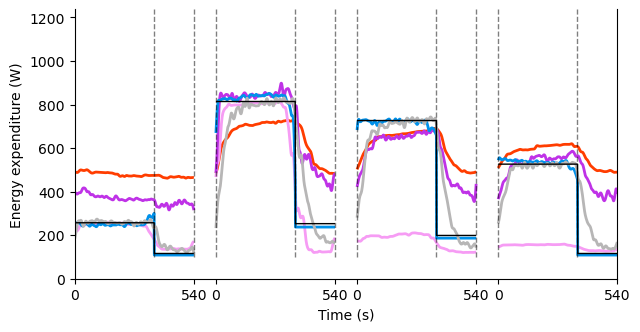

In [3]:
# Plotting 4 conditions and their return to rest averaged over all subjects
from scipy import signal
def low_pass_filt(vector):
    wn = 6
    data_rate = 100
    filt_order = 4
    b,a = signal.butter(filt_order, wn, fs=data_rate)
    filt_vector = signal.filtfilt(b,a,vector)
    return filt_vector

num_subjects,num_conds_ss,_ = hr_int.shape #[num_subjs, num_conds, ts]
saving_flag = saving
lnwd = 2
cond_ss_plot_inds = np.array([0,3,5,7])
lab_watch = 'Smartwatch'
lab_watch_as = 'Activity Specific Smartwatch'
lab_hr = 'Heart Rate Model'

cond_mult = np.zeros(8)
for i in range(8):
    cond_subj_inds = np.sum(ss_true_inds[:,i])
    cond_mult[i] = num_subjects*1.0/cond_subj_inds

def avg_subj_plot(data_mat,conditions, cond_mult2 = np.ones(num_conds_ss)):
    subj_avg = np.mean(data_mat, axis=0) * np.expand_dims(cond_mult2, axis=1)
    return subj_avg[conditions].flatten()

hr_int = hr_int*np.expand_dims(ss_true_inds,axis=-1)
hr_avg_vector = avg_subj_plot(hr_int, cond_ss_plot_inds, cond_mult)
# setting up the dd vector, avg by subjects, then add basal rate between them
vec_len = hr_avg_vector.shape

dd_subj_avg = np.mean(dd_int,axis=0)
dd_avg_basal = np.mean(basal_rate_list)
dd_avg_vector = np.zeros(vec_len[0])
met_real_vector = np.zeros(vec_len[0])
met_subj_avg = np.mean(met_real,axis=0)
met_avg_basal = np.mean(stand_est[0])
cond_len = 60*6

space_btwn = 100
for i,cond in enumerate(cond_ss_plot_inds):
    start_idx = i*(vec_len[0]//4)
    end_idx = (i+1)*(vec_len[0]//4)
    dd_avg_vector[start_idx:end_idx] = np.concatenate((dd_subj_avg[cond,:], np.ones(180)*dd_avg_basal), axis=0)
    met_real_vector[start_idx:end_idx] = np.concatenate((np.ones(360)*met_subj_avg[cond], np.ones(180)*met_avg_basal), axis=0)
    dd_avg_vector[start_idx:start_idx+cond_len] = low_pass_filt(dd_avg_vector[start_idx:start_idx+cond_len])

fig, ax = plt.subplots(1, 1, figsize = [plt_double_width, plt_height])
x_inds = []
x_inds2 = []
# plotting processed data
cnd_inds = [1,3,5,7]
for i,cond in enumerate(cond_ss_plot_inds):
    start_idx = i*(vec_len[0]//4)
    end_idx = (i+1)*(vec_len[0]//4)
    x_inds.append(start_idx+i*space_btwn)
    x_inds.append(start_idx+i*space_btwn+cond_len)
    x_inds2.append(start_idx+i*space_btwn)
    x_inds2.append(end_idx+i*space_btwn)
    x_inds.append(end_idx+i*space_btwn)

    t_vec = np.linspace(start_idx+i*space_btwn, end_idx+i*space_btwn,540)
    ax.plot(t_vec, low_pass_filt(hr_avg_vector[start_idx:end_idx]), c=red, label=lab_hr, linewidth=lnwd, solid_capstyle='butt')
    ax.plot(t_vec, low_pass_filt(avg_subj_plot(watch_int,cond_ss_plot_inds)[start_idx:end_idx]*cond_mult[cnd_inds[i]]), c=purple, label=lab_watch, linewidth=lnwd, solid_capstyle='butt')
    ax.plot(t_vec, low_pass_filt(avg_subj_plot(watch_as_int,cond_ss_plot_inds)[start_idx:end_idx]*cond_mult[cnd_inds[i]]), c=purple_as, label=lab_watch_as, linewidth=lnwd, solid_capstyle='butt')
    ax.plot(t_vec,dd_avg_vector[start_idx:end_idx]*cond_mult[cnd_inds[i]], c=blue, label=lab_dd, linewidth=lnwd, solid_capstyle='butt')
    ax.plot(t_vec,low_pass_filt(avg_subj_plot(met_int,cond_ss_plot_inds)[start_idx:end_idx]*cond_mult[cnd_inds[i]]), c=grey, label=lab_met_bb, linewidth=lnwd, solid_capstyle='butt')
    ax.plot(t_vec,met_real_vector[start_idx:end_idx]*cond_mult[cnd_inds[i]], c='k', label=lab_met_avg, linewidth=lnwd*0.5, solid_capstyle='butt')
ax.spines['top'].set_color('none')
#ax.spines['right'].set_color('none')
ax.set_ylabel('Energy expenditure (W)')
ax.set_xlabel('Time (s)')    
# get ylim and add additional offset
ylow, yhigh = ax.get_ylim()
yhigh = yhigh + 300
ax.set_ylim(bottom=0, top=yhigh)  
ax.set_xlim(left=0,right=len(met_real_vector)+3*space_btwn)

ax.set_xticks(x_inds2, minor=False)
ax.set_xticklabels([0,540,0,540,0,540,0,540], minor=False)

# adding vertical dashed lines
for x_ind in x_inds[1:-1]:
    plt.plot([x_ind-1,x_ind-1],[101,yhigh], c='k', alpha=0.5, linewidth = lnwd*0.5, linestyle='--')

if saving_flag:
    filename = "SS_subj_avg"
    plt.savefig(save_dir+filename+".svg", bbox_inches = 'tight', dpi=1200, pad_inches = 0)
    plt.savefig(save_dir+filename+".png", bbox_inches = 'tight', dpi=1200, pad_inches = 0)
plt.show()

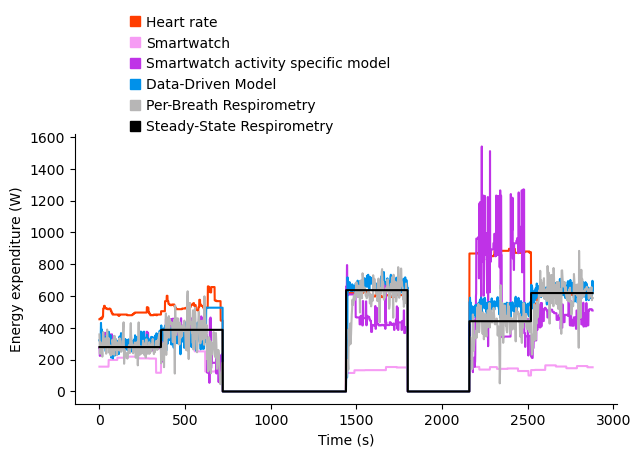

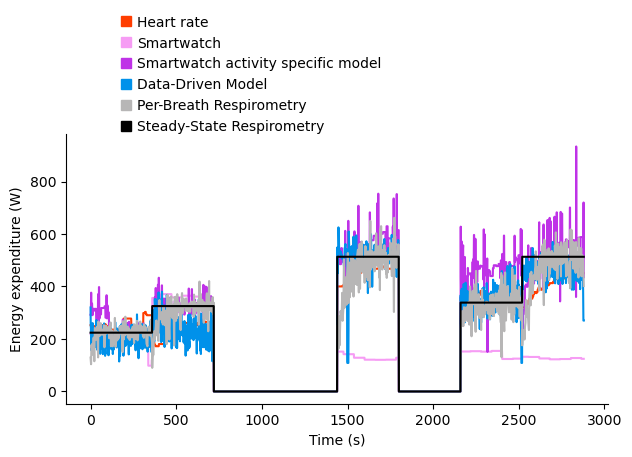

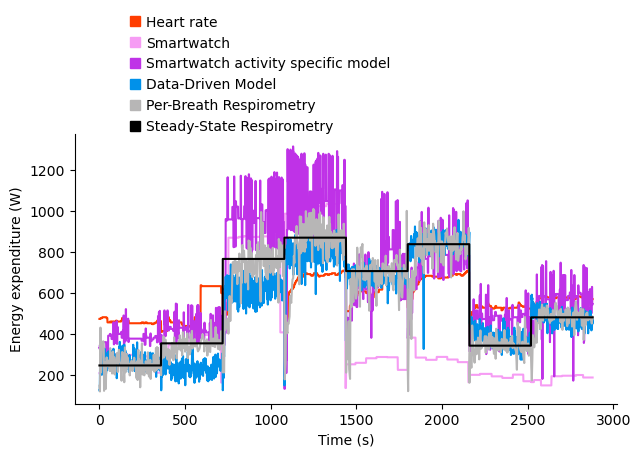

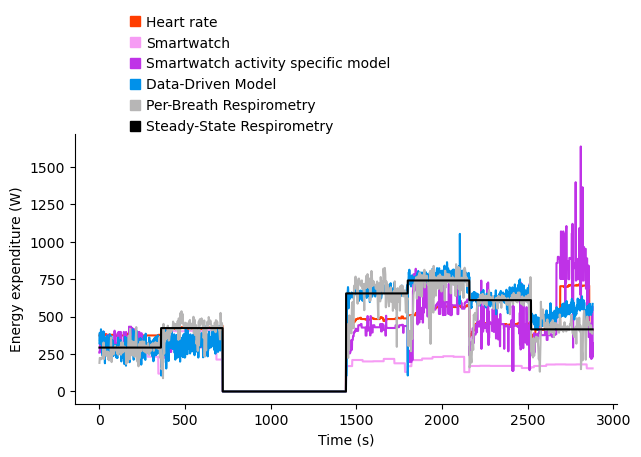

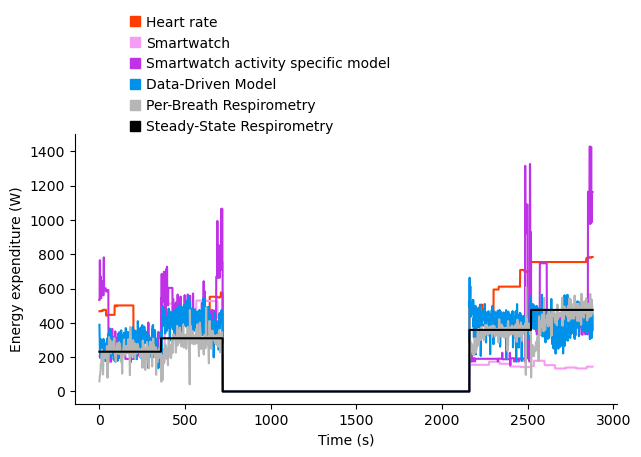

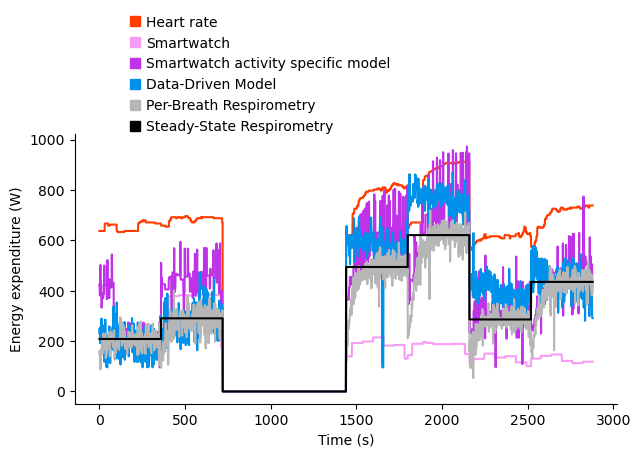

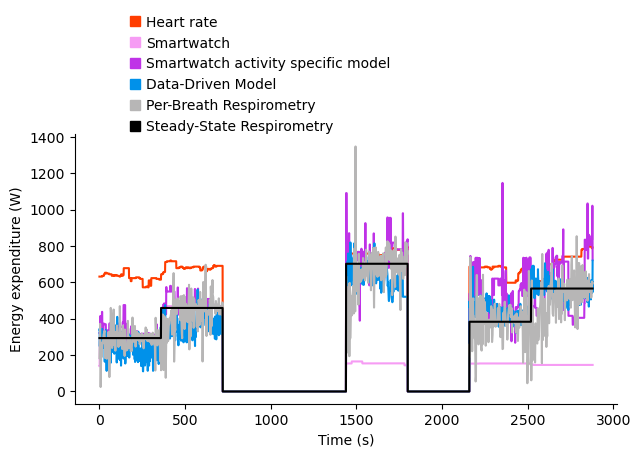

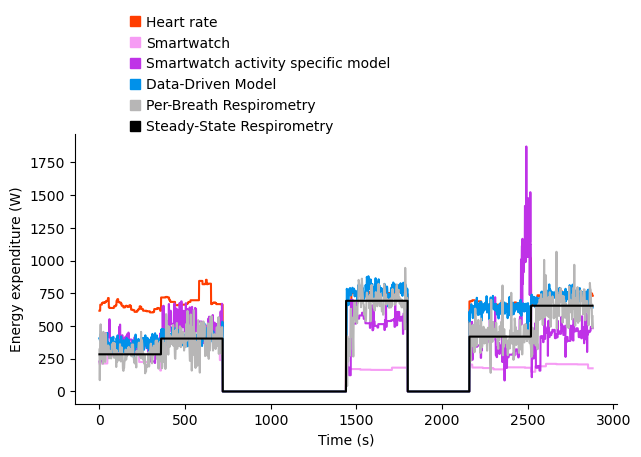

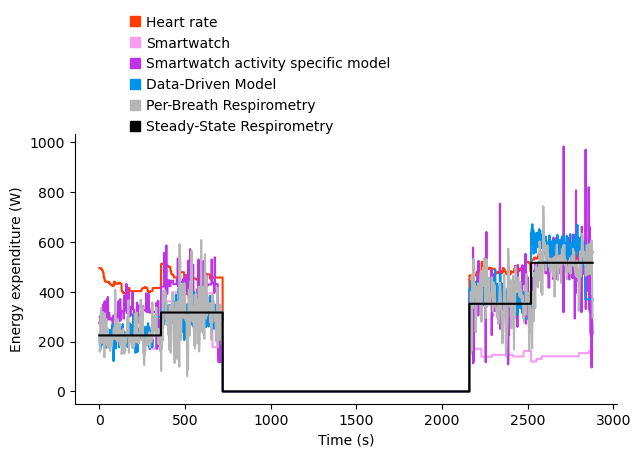

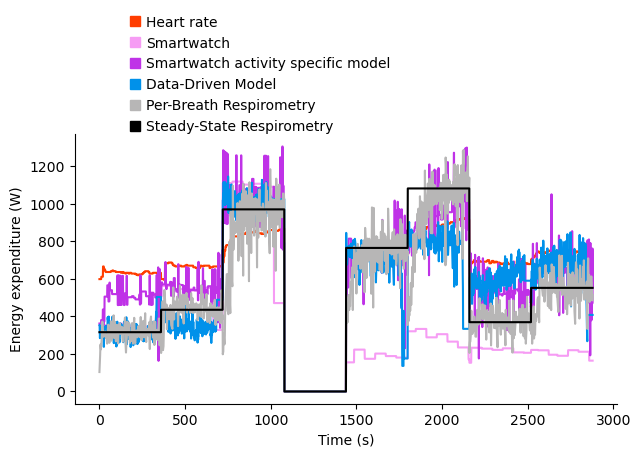

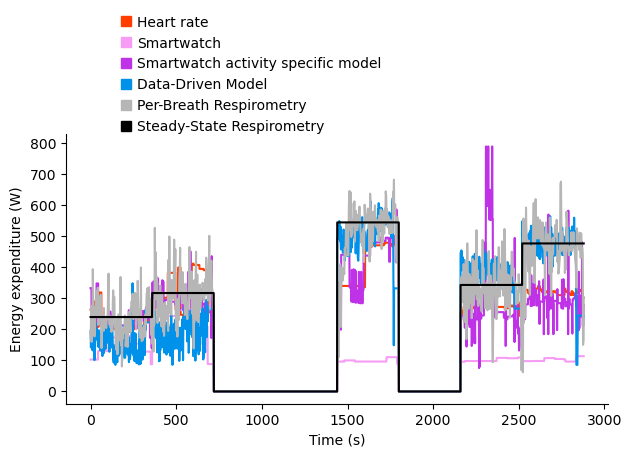

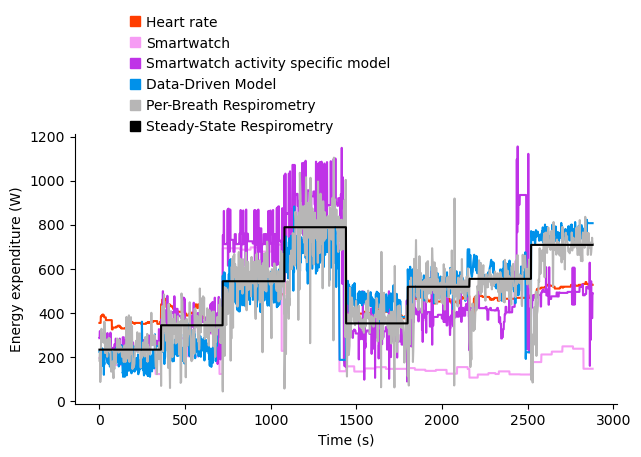

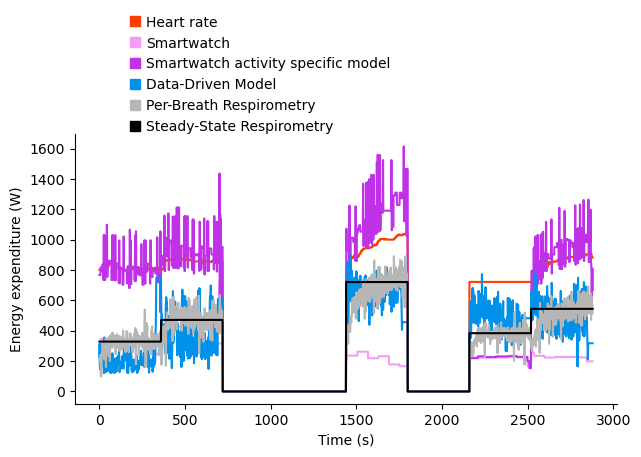

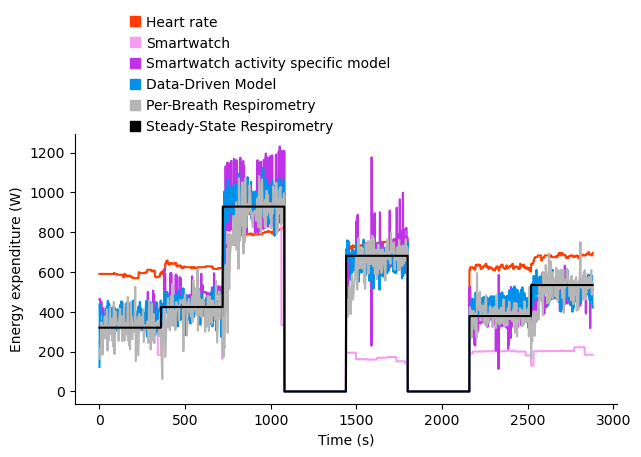

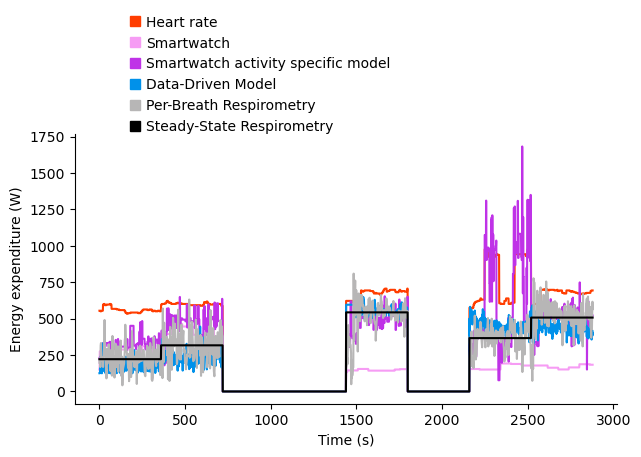

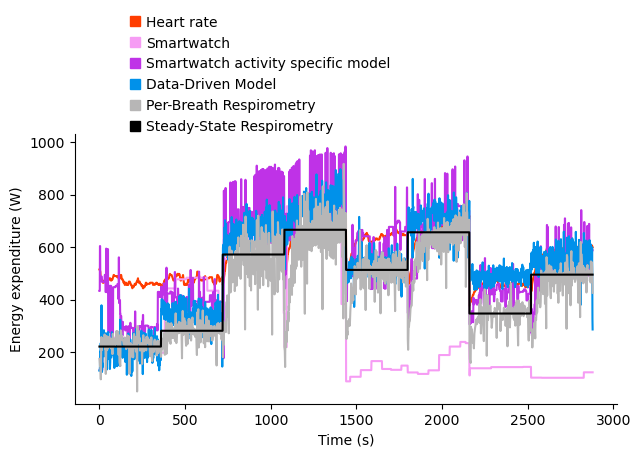

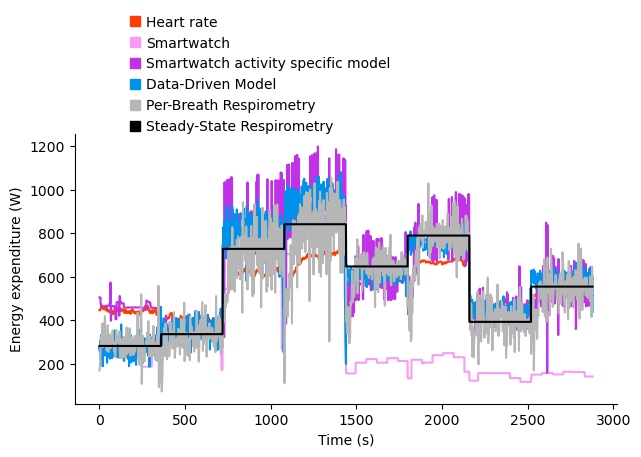

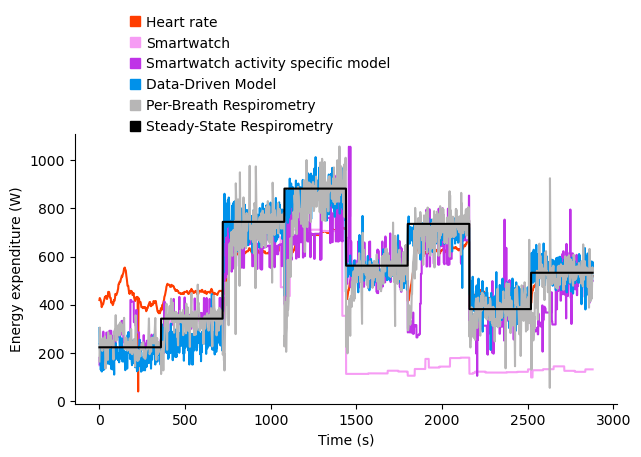

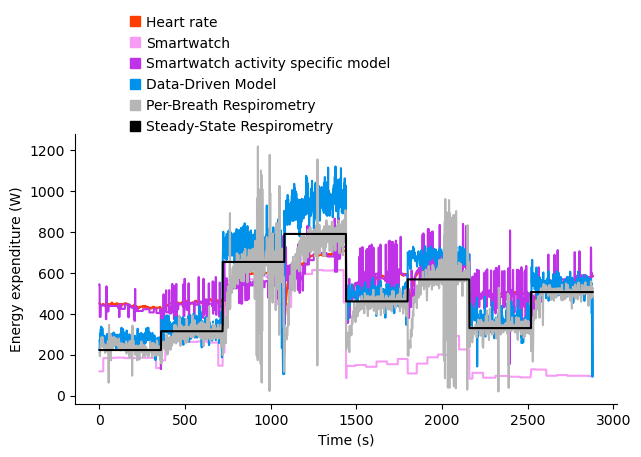

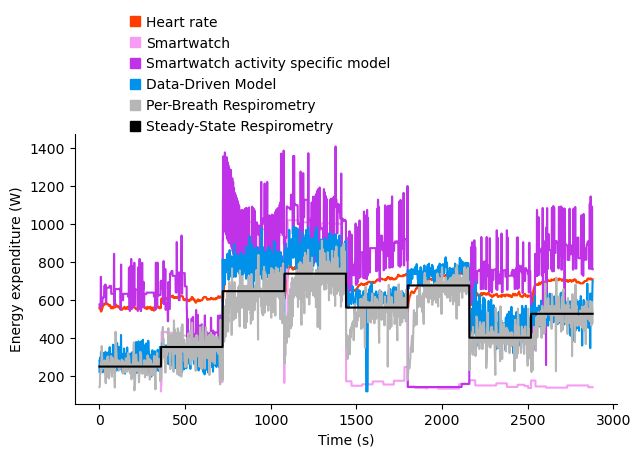

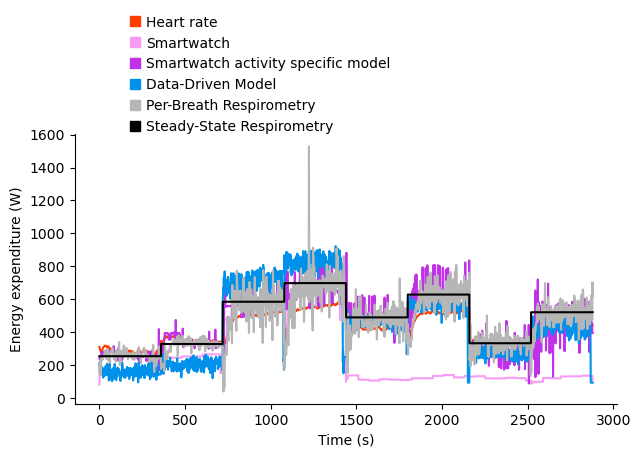

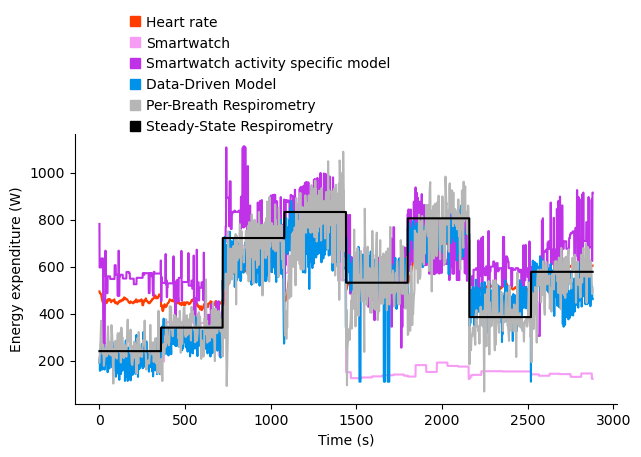

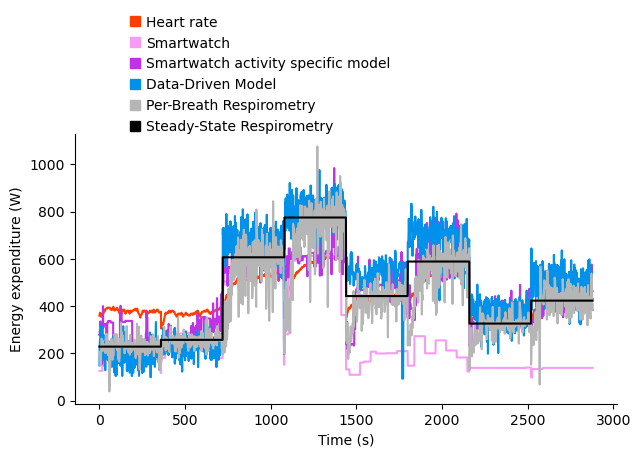

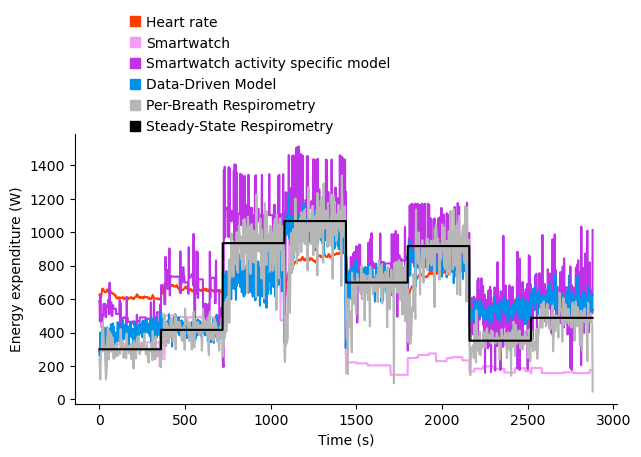

In [4]:
# Plotting the raw signals over all conditions
num_subjects,_,_ = hr_int.shape
saving_flag = saving
for i in range(num_subjects):
    subj_ind = i
    time_end = 360
    lab_watch = 'Smartwatch'
    lab_watch_as = 'Smartwatch activity specific model'
    lab_hr = 'Heart rate'
    def ts_plot(data_mat,subj_ind,time_end):
        return data_mat[subj_ind,:,:time_end].flatten()
    fig, ax = plt.subplots(1, 1, figsize = [plt_double_width, plt_height]) #[1, 1, 0.6]})

    ax.plot(ts_plot(hr_int,subj_ind,time_end), c=red, label=lab_hr)
    ax.plot(ts_plot(watch_int,subj_ind,time_end), c=purple, label=lab_watch)
    ax.plot(ts_plot(watch_as_int,subj_ind,time_end), c=purple_as, label=lab_watch_as)
    ax.plot(ts_plot(dd_int,subj_ind,time_end), c=blue, label=lab_dd)
    ax.plot(ts_plot(met_int,subj_ind,time_end), c=grey, label=lab_met_bb)
    met_real_re = np.tile(np.expand_dims(met_real[i,:],axis=1),time_end).flatten()
    ax.plot(met_real_re, c='k', label=lab_met_avg)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.set_ylabel('Energy expenditure (W)')
    ax.set_xlabel('Time (s)')      
    # updating the legend style
    plt.rcParams['legend.handlelength'] = 0.0
    plt.legend(loc=(0.1, 0.98), frameon=False, handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})

    if saving_flag:
        filename = "SS_ind_ts_plot_" + str(i)
        plt.savefig(save_dir+filename+".png", bbox_inches = 'tight', dpi=600, pad_inches = 0)
    plt.show()

In [5]:
### Computing results
ss_num_conds = 8 # first conds are steady state
# SS mean and y_err values
half_cond = 180
cond_len = 360

def elim_unused(vec, inds_vec):
    if len(vec.shape) == 1:
        inds = np.nonzero(inds_vec)[0]
        return vec[inds]
    elif len(vec.shape) == 2:
        inds = np.nonzero(inds_vec)[0]
        return vec[inds,:]
    else:
        print("Unexpected vec shape:", vec.shape)

ss_hr_vec2 = ape(np.mean(hr_int[:,:ss_num_conds,half_cond:cond_len], axis=-1).flatten(), met_true_vec) #ape(hr_fo_int[:,:ss_num_conds,-1].flatten(), met_true_vec)
ss_hr_vec = elim_unused(ss_hr_vec2, ss_true_inds.flatten())
ss_hr_mean, ss_hr_yerr = compErrBars(ss_hr_vec, upper_perc, lower_perc)
ss_watch_vec2 = ape(np.mean(watch_int[:,:ss_num_conds,half_cond:cond_len], axis=-1).flatten(), met_true_vec) #ape(watch_fo_int[:,:ss_num_conds,-1].flatten(), met_true_vec)
ss_watch_vec = elim_unused(ss_watch_vec2, ss_true_inds.flatten())
ss_watch_mean, ss_watch_yerr = compErrBars(ss_watch_vec, upper_perc, lower_perc)
ss_watch_as_vec2 = ape(np.mean(watch_as_int[:,:ss_num_conds,half_cond:cond_len], axis=-1).flatten(), met_true_vec) #ape(watch_fo_int[:,:ss_num_conds,-1].flatten(), met_true_vec)
ss_watch_as_vec = elim_unused(ss_watch_as_vec2, ss_true_inds.flatten())
ss_watch_as_mean, ss_watch_as_yerr = compErrBars(ss_watch_as_vec, upper_perc, lower_perc)
ss_dd_vec2 = ape(np.mean(dd_int[:,:ss_num_conds,180:], axis=2).flatten(), met_true_vec)
ss_dd_vec = elim_unused(np.copy(ss_dd_vec2), ss_true_inds.flatten())
ss_dd_mean, ss_dd_yerr = compErrBars(ss_dd_vec, upper_perc, lower_perc)
ss_met_vec2 = ape(met_fo_int[:,:ss_num_conds,-1].flatten(), met_true_vec)
ss_met_vec = elim_unused(ss_met_vec2, ss_true_inds.flatten())
ss_met_mean, ss_met_yerr = compErrBars(ss_met_vec, upper_perc, lower_perc)

# Convergence vectors [119]
ss_conv_hr = mape(elim_unused(np.reshape(hr_int[:,:ss_num_conds,1:120], (-1,119)), ss_true_inds.flatten()), elim_unused(met_true_vec, ss_true_inds.flatten())) #mape(np.reshape(hr_fo_int[:,:ss_num_conds,:], (-1,119)), met_true_vec)
ss_conv_watch = mape(elim_unused(np.reshape(watch_int[:,:ss_num_conds,1:120], (-1,119)), ss_true_inds.flatten()), elim_unused(met_true_vec, ss_true_inds.flatten()))
ss_conv_watch_as = mape(elim_unused(np.reshape(watch_as_int[:,:ss_num_conds,1:120], (-1,119)), ss_true_inds.flatten()), elim_unused(met_true_vec, ss_true_inds.flatten()))
ss_conv_dd = mape(elim_unused(np.reshape(dd_int[:,:ss_num_conds,1:120], (-1,119)), ss_true_inds.flatten()), elim_unused(met_true_vec, ss_true_inds.flatten()))
ss_conv_dd[:6] = ss_conv_dd[:6] - 3
met_fo_inds = np.mean(np.reshape(met_fo_int[:,:ss_num_conds,:], (-1,119)), axis=1)
ss_conv_met = mape(elim_unused(np.reshape(met_fo_int[:,:ss_num_conds,:], (-1,119)), met_fo_inds), elim_unused(met_true_vec, met_fo_inds))
ss_conv_met2 = mape(elim_unused(np.reshape(met_int[:,:ss_num_conds,1:120], (-1,119)), ss_true_inds.flatten()), elim_unused(met_true_vec, ss_true_inds.flatten()))#mape(np.reshape(met_int[:,:ss_num_conds,1:120], (-1,119)), met_true_vec)
crossover_err = np.argmax(ss_conv_met<ss_conv_dd)

# Cum error
# avg rate over full 9 minutes, subtracting standing off of the last 3 minutes
num_subjs,_,_ = hr_int.shape
dd_sc_cum = np.mean(dd_int[:,:ss_num_conds,:], axis=-1).flatten()
def computeTotEE(data_mat, stand_offset, cond_len=360): # data_mat = [subj, cond, time_s]
    cond_ee = data_mat[:,:,:cond_len]
    extra_ee = data_mat[:,:,cond_len:]
    extra_ee = extra_ee - np.expand_dims(np.expand_dims(stand_offset,axis=1),axis=1)
    extra_val = np.mean(extra_ee, axis=-1)/2.0 # take mean ee and divide by 2 since adding to twice as long of an interval
    cond_ee_avg = np.mean(cond_ee,axis=-1) + extra_val
    return cond_ee_avg.flatten() # [subj, cond]

# stand_est is met, hr, and watch
hr_sc_cum = computeTotEE(hr_int, stand_est[1,:])
met_sc_cum = computeTotEE(met_int, stand_est[0,:])
watch_sc_cum = computeTotEE(watch_int, stand_est[2,:])
watch_as_sc_cum = computeTotEE(watch_as_int, stand_est[2,:])

# computing percent error using met_sc
ss_hr_cum_vec = ape(hr_sc_cum, met_sc_cum)
ss_hr_cum_vec = elim_unused(ss_hr_cum_vec, ss_true_inds.flatten())
ss_hr_cum_mean, ss_hr_cum_yerr = compErrBars(ss_hr_cum_vec, upper_perc, lower_perc)
ss_watch_cum_vec = ape(watch_sc_cum, met_sc_cum)
ss_watch_cum_vec = elim_unused(ss_watch_cum_vec, ss_true_inds.flatten())
ss_watch_cum_mean, ss_watch_cum_yerr = compErrBars(ss_watch_cum_vec, upper_perc, lower_perc)
ss_watch_as_cum_vec = ape(watch_as_sc_cum, met_sc_cum)
ss_watch_as_cum_vec = elim_unused(ss_watch_as_cum_vec, ss_true_inds.flatten())
ss_watch_as_cum_mean, ss_watch_as_cum_yerr = compErrBars(ss_watch_as_cum_vec, upper_perc, lower_perc)
ss_dd_cum_vec = ape(dd_sc_cum, met_sc_cum)
ss_dd_cum_vec = elim_unused(ss_dd_cum_vec, ss_true_inds.flatten())
ss_dd_cum_mean, ss_dd_cum_yerr = compErrBars(ss_dd_cum_vec, upper_perc, lower_perc)
print("Cumulative errors:",ss_hr_cum_mean,ss_dd_cum_mean,ss_watch_cum_mean, ss_watch_as_cum_mean)

def compErrBars3(data_vec, upper_perc, lower_perc, ss_true_inds):
    data_vec_mean = np.zeros(8)
    for i in range(8):
        subj_cond_inds = np.nonzero(ss_true_inds[:,i])[0]
        data_vec_mean[i] = np.mean(data_vec[subj_cond_inds,i])
    y_err_bars_vec = []
    for i in range(8):
        subj_cond_inds = np.nonzero(ss_true_inds[:,i])[0]
        y_err_ind = np.expand_dims(np.abs(np.percentile(data_vec[subj_cond_inds,i],[upper_perc, lower_perc]) - data_vec_mean[i]), axis=1)
        y_err_bars_vec.append(y_err_ind)
    return data_vec_mean, np.array(y_err_bars_vec)[:,:,0].T

ss_sc_hr_vec = np.reshape(ss_hr_vec2, (-1,8))
ss_sc_watch_vec = np.reshape(ss_watch_vec2, (-1,8))
ss_sc_watch_as_vec = np.reshape(ss_watch_as_vec2, (-1,8))
ss_sc_dd_vec = np.reshape(ss_dd_vec2, (-1,8))

sc_hr_mean, sc_hr_yerr = compErrBars3(ss_sc_hr_vec, upper_perc, lower_perc, ss_true_inds)

sc_watch_mean = np.mean(ss_sc_watch_vec, axis=0)
sc_watch_std = np.std(ss_sc_watch_vec, axis=0)
sc_watch_mean, sc_watch_yerr = compErrBars3(ss_sc_watch_vec, upper_perc, lower_perc, ss_true_inds)

sc_watch_as_mean = np.mean(ss_sc_watch_as_vec, axis=0)
sc_watch_as_std = np.std(ss_sc_watch_as_vec, axis=0)
sc_watch_as_mean, sc_watch_as_yerr = compErrBars3(ss_sc_watch_as_vec, upper_perc, lower_perc, ss_true_inds)

sc_dd_mean = np.mean(ss_sc_dd_vec, axis=0)
sc_dd_std = np.std(ss_sc_dd_vec, axis=0)
sc_dd_mean, sc_dd_yerr = compErrBars3(ss_sc_dd_vec, upper_perc, lower_perc, ss_true_inds)

Cumulative errors: 70.8446425624794 13.168174473848007 50.60036168610894 37.854846526040575


c:\users\patty\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


c:\users\patty\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
c:\users\patty\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


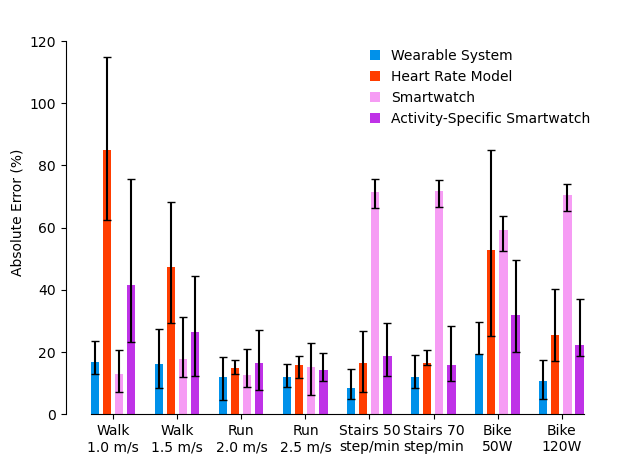

In [6]:
fig, ax = plt.subplots(1, 1, figsize = [plt_double_width, plt_height*1.5])#, gridspec_kw={'height_ratios': [0.45, 1], 'width_ratios': [0.15, 1]})
x_labels = ('Walk\n1.0 m/s', 'Walk\n1.5 m/s', 'Run\n2.0 m/s', 'Run\n2.5 m/s', 'Stairs 50\nstep/min', 'Stairs 70\nstep/min', 'Bike\n50W', 'Bike\n120W')
idx = np.arange(len(x_labels))
bar_width2 = 0.13
bar_spacing2 = 0.06
dd_bar = ax.bar(idx, sc_dd_mean, bar_width2, color=blue, label="Wearable System", yerr=sc_dd_yerr, ecolor='k', capsize=err_capsize)
hr_bar = ax.bar(idx+ 1*bar_width2 + 1*bar_spacing2, sc_hr_mean, bar_width2, color=red, label="Heart Rate Model", yerr=sc_hr_yerr, ecolor='k', capsize=err_capsize)
watch_bar = ax.bar(idx+ 2*bar_width2 + 2*bar_spacing2, sc_watch_mean, bar_width2, color=purple, label="Smartwatch", yerr=sc_watch_yerr, ecolor='k', capsize=err_capsize)
watch_as_bar = ax.bar(idx+ 3*bar_width2 + 3*bar_spacing2, sc_watch_as_mean, bar_width2, color=purple_as, label="Activity-Specific Smartwatch", yerr=sc_watch_as_yerr, ecolor='k', capsize=err_capsize)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_ylim([0.0, 130.0])
ax.set_xticks(idx + 2*bar_width2 + 0.5*bar_spacing2, minor=False)
ax.set_xticklabels(x_labels, minor=False)
ax.set_ylabel('Absolute Error (%)')
plt.rcParams['legend.handlelength'] = 0.7

ax.legend(loc=(0.55,0.7), frameon=False, handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})
ax.spines['bottom'].set_smart_bounds(True)
ax.spines['left'].set_smart_bounds(True)

if saving:
    filename = "SS_ind_activities_plot"
    plt.savefig(save_dir+filename+".svg", bbox_inches = 'tight', dpi=300, pad_inches = 0)
    plt.savefig(save_dir+filename+".png", bbox_inches = 'tight', dpi=900, pad_inches = 0)
plt.show()


c:\users\patty\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
c:\users\patty\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:68: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


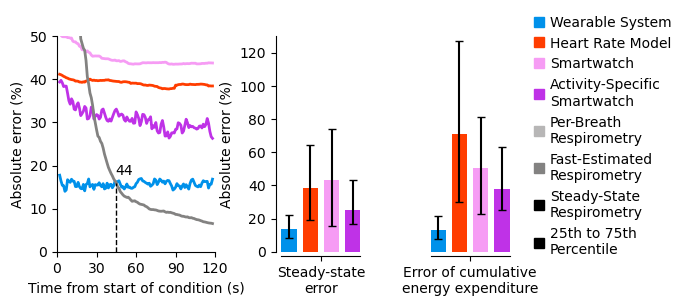

In [7]:
stop_ind = 2
t = np.arange(2,121-stop_ind)
max_y_err = 50.0
lab_watch_ind = 'Smartwatch activity specific\nfirst order fit'
lab_watch_as_ind = 'Smartwatch'
lab_hr_fo = 'Heart rate first order fit'
lab_met_fo = 'Respirometry first order fit'
lab_watch = 'Smartwatch'
lab_watch_as = 'Smartwatch activity specific model'
lab_hr = 'Heart rate'
txt_x = crossover_err - 2
txt_y = ss_conv_met2[crossover_err] + 3.2
txt_s = str(crossover_err+1)

fig, ax = plt.subplots(1,4,figsize = [plt_double_width, plt_height*0.8], gridspec_kw={'width_ratios': [2, 1.1, 1.1, 0.3]})
labels = ['Heart Rate Model', 'Activity-Specific\nSmartwatch','Wearable System','Per-Breath\nRespirometry', 'Smartwatch']
c = [red,purple_as,blue,grey,purple] # should 2 min met est be black or grey?
plot_ord = [2,0,4,1,3]
y_max=130.0
lnwd =2
# first plot for the error as a function of time from the start of the condition
plt_idx = 0
ax[plt_idx].plot(t, ss_conv_hr[:-stop_ind], label=lab_hr, color=red, linewidth=lnwd)
ax[plt_idx].plot(t, ss_conv_watch[:-stop_ind], label=lab_watch, color=purple, linewidth=lnwd)
ax[plt_idx].plot(t, ss_conv_watch_as[:-stop_ind], label=lab_watch_as, color=purple_as, linewidth=lnwd)
ax[plt_idx].plot(t, ss_conv_dd[:-stop_ind], label=lab_dd, color=blue, linewidth=lnwd)#, marker='o',markersize=msize)
ax[plt_idx].plot(t, ss_conv_met[:-stop_ind], label=lab_met_fo, color=dark_grey, linewidth=lnwd)
ax[plt_idx].plot([crossover_err+2,crossover_err+2], [0, ss_conv_met[crossover_err]], color='k', linestyle ='--', linewidth=lnwd*0.5) #label='First gait estimate', 
ax[plt_idx].set_ylim(top=max_y_err, bottom=0.0)
ax[plt_idx].set_xlim((t[0]-1,t[-1]))
ax[plt_idx].text(txt_x+3, txt_y-3, txt_s)
ax[plt_idx].set_ylabel('Absolute error (%)')
ax[plt_idx].set_xlabel('Time from start of condition (s)')
ax[plt_idx].spines['top'].set_color('none')
ax[plt_idx].spines['right'].set_color('none')
ax[plt_idx].set_xticks([0,30,60,90,120], minor=False)

# second figure for bar plot for absolute mean error over time
idx = 0
plt_idx = 1
dd_bar = ax[plt_idx].bar(idx, [ss_dd_mean], bar_width, color=blue, label=lab_dd, yerr=ss_dd_yerr, ecolor='k', capsize=err_capsize)
hr_bar = ax[plt_idx].bar(idx + 1*bar_width + bar_spacing, [ss_hr_mean], bar_width, color=red, label=lab_hr, yerr=ss_hr_yerr, ecolor='k', capsize=err_capsize)
watch_bar = ax[plt_idx].bar(idx+ 2*bar_width + 2*bar_spacing, [ss_watch_mean], bar_width, color=purple, label=lab_watch, yerr=ss_watch_yerr, ecolor='k', capsize=err_capsize)
watch_as_bar = ax[plt_idx].bar(idx+ 3*bar_width + 3*bar_spacing, [ss_watch_as_mean], bar_width, color=purple_as, label=lab_watch_as, yerr=ss_watch_as_yerr, ecolor='k', capsize=err_capsize)
ax[plt_idx].set_ylabel('Absolute error (%)')
ax[plt_idx].spines['top'].set_color('none')
ax[plt_idx].spines['right'].set_color('none')
ax[plt_idx].spines['bottom'].set_smart_bounds(True)
ax[plt_idx].spines['bottom'].set_position(('axes', axes_spacing_bottom))
ax[plt_idx].spines['left'].set_position(('axes', axes_spacing_left-0.03))
ax[plt_idx].set_xticks([1.5*bar_width + 1.5*bar_spacing], minor=False)
ax[plt_idx].set_xticklabels(['Steady-state\nerror'], minor=False)
ax[plt_idx].set_ylim(bottom=0,top=y_max)

# third figure for bar plot for absolute mean error
plt_idx = 2
idx = 0
bar_spacing2 = bar_spacing

dd_bar = ax[plt_idx].bar(idx, [ss_dd_cum_mean], bar_width, color=blue, label=lab_dd, yerr=ss_dd_cum_yerr, ecolor='k', capsize=err_capsize)
hr_bar = ax[plt_idx].bar(idx+ 1*bar_width + 1*bar_spacing, [ss_hr_cum_mean], bar_width, color=red, label=lab_hr, yerr=ss_hr_cum_yerr, ecolor='k', capsize=err_capsize)
watch_bar = ax[plt_idx].bar(idx+ 2*bar_width + 2*bar_spacing, [ss_watch_cum_mean], bar_width, color=purple, label=lab_watch, yerr=ss_watch_cum_yerr, ecolor='k', capsize=err_capsize)
watch_as_bar = ax[plt_idx].bar(idx+ 3*bar_width + 3*bar_spacing, [ss_watch_as_cum_mean], bar_width, color=purple_as, label=lab_watch_as, yerr=ss_watch_as_cum_yerr, ecolor='k', capsize=err_capsize)

ax[plt_idx].spines['top'].set_color('none')
ax[plt_idx].spines['right'].set_color('none')
ax[plt_idx].spines['left'].set_color('none')
ax[plt_idx].spines['bottom'].set_smart_bounds(True)
ax[plt_idx].spines['bottom'].set_position(('axes', axes_spacing_bottom))
ax[plt_idx].spines['left'].set_position(('axes', axes_spacing_left))
ax[plt_idx].set_xticks([1.5*bar_width + 1.5*bar_spacing2], minor=False)
ax[plt_idx].set_yticks([], minor=False)
ax[plt_idx].set_xticklabels(['Error of cumulative\nenergy expenditure'], minor=False)
ax[plt_idx].set_ylim(bottom=0,top=y_max)

# plot just for legend
plt_idx = 3
ax[plt_idx].set_xticks([], minor=False)
ax[plt_idx].set_xticklabels([], minor=False)
ax[plt_idx].set_yticks([], minor=False)
ax[plt_idx].set_yticklabels([], minor=False)
ax[plt_idx].spines['top'].set_color('none')
ax[plt_idx].spines['right'].set_color('none')
ax[plt_idx].spines['left'].set_color('none')
ax[plt_idx].spines['bottom'].set_color('none')

# fourth plot for legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=c[plot_ord[0]]),
                Line2D([0], [0], color=c[plot_ord[1]]),
                Line2D([0], [0], color=c[plot_ord[2]]),
                Line2D([0], [0], color=c[plot_ord[3]]),
                Line2D([0], [0], color=c[plot_ord[4]]),
                Line2D([0], [0], color=dark_grey),
                Line2D([0], [0], color=black),
                Line2D([0], [0], color=black)]
plt.rcParams['legend.handlelength'] = 0.0
ax[plt_idx].legend(custom_lines, [labels[plot_ord[0]],labels[plot_ord[1]],"Smartwatch",labels[plot_ord[3]],labels[plot_ord[4]], 'Fast-Estimated\nRespirometry','Steady-State\nRespirometry', '25th to 75th\nPercentile'], loc=(-1.8,-0.05),frameon=False, handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})
plt.subplots_adjust(wspace=0.7)
if saving:
    filename = "SS_second_line_plot"
    plt.savefig(save_dir+filename+".svg", bbox_inches = 'tight', dpi=300, pad_inches = 0)
    plt.savefig(save_dir+filename+".png", bbox_inches = 'tight', dpi=900, pad_inches = 0)
plt.show()

In [8]:
tv_mat = np.load(data_dir+'tv_mat.npy')
cond_per = [24,30,30,30]
data_period_avg = np.load(data_dir+'data_period_avg.npy')
data_period_std = np.load(data_dir+'data_period_std.npy')
data_per_avg = np.load(data_dir+'data_per_avg.npy')
# load the tv raw values [subj, cond, 360] # watch, met, hr, dd
met_int_tv = np.load(data_dir+'met_int_tv.npy') 
watch_int_tv = np.load(data_dir+'watch_int_tv.npy')
watch_as_int_tv = np.load(data_dir+'watch_as_int_tv.npy') 
hr_int_tv = np.load(data_dir+'hr_int_tv.npy') 
dd_int_tv = np.load(data_dir+'dd_int_tv.npy') 

def computeTotEETV(data_mat, stand_offset, cond_len=360): # data_mat = [subj, cond, time_s]
    cond_ee = data_mat[:,:cond_len]
    extra_ee = data_mat[:,cond_len:]
    extra_ee = extra_ee - np.expand_dims(stand_offset,axis=1)
    extra_val = np.mean(extra_ee, axis=-1)/2.0 # take mean ee and divide by 2 since adding to twice as long of an interval
    cond_ee_avg = np.mean(cond_ee,axis=-1) + extra_val
    return cond_ee_avg # [subj]

c:\users\patty\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:145: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


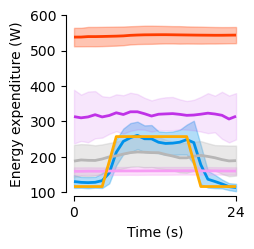

c:\users\patty\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:145: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


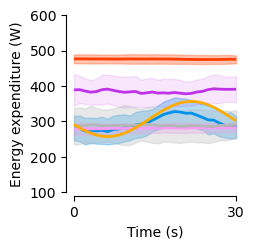

c:\users\patty\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:145: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


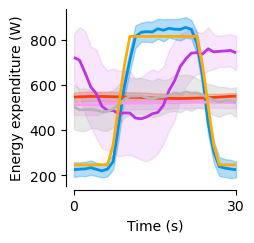

c:\users\patty\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:145: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


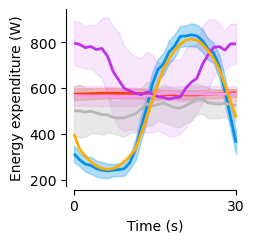

In [9]:
# combining avg, time-varying, and bar chart of results

tv_inds = true_inds[-4:,:] # 4 tv x subjs
tot_abs_err_bars = np.zeros((4,5,2,1)) # [tv_conds, signals, 2, 1]
tot_abs_mean_bars = np.zeros((4,5))
tot_cum_err_bars = np.zeros((4,5,2,1))
tot_cum_mean_bars = np.zeros((4,5))
feats,conds,subjs,iters,steps = data_per_avg.shape
data_per_avg_re = np.reshape(data_per_avg, (feats,conds,subjs*iters,steps))
tv_mat_mean = np.expand_dims(np.expand_dims(np.mean(tv_mat,axis=-1,keepdims=True),axis=0), axis=2)
data_offset = np.mean(data_per_avg_re, axis=-1, keepdims=True)
feat_mean_shift = tv_mat_mean - data_offset 
data_rel_avg = data_per_avg_re + feat_mean_shift # [feats, conds, subj*iters, steps]
data_abs_mean = np.mean(data_per_avg_re,axis=-1) # [feats, conds, subj*iters]
tv_var_mean = np.mean(tv_mat,axis=-1)
num_tv_conds = 4
abs_tv_conds = np.zeros((num_tv_conds, feats))
cum_tv_conds = np.zeros((num_tv_conds, feats))
abs_tv_subjiter = np.zeros((feats,subjs*iters))

dd_tv_cum_subj_vec = []
hr_tv_cum_subj_vec = []
watch_tv_cum_subj_vec = []
watch_as_tv_cum_subj_vec = []
tot_abs_std = np.zeros((num_tv_conds, feats))

# offset adjust
data_period_avg[2,1,:] = data_period_avg[2,1,:]+16
for tv_ind in range(num_tv_conds):
    per_len = cond_per[tv_ind]
    t_avg = np.arange(0,per_len)
    alpha1 = 0.3
    plot_ord = [2,0,4,1,3]
    num_plot_vars = feats

    # computing cumulative error of each feature  # data_per_avg [feats, conds, subj, iters, steps] with feats: hr, watch, dd, met
    subj_cond_inds = np.nonzero(tv_inds[tv_ind,:])[0]
    dd_tv_cum = np.mean(dd_int_tv[subj_cond_inds,tv_ind,:], axis=-1).flatten()
    hr_tv_cum = computeTotEETV(hr_int_tv[subj_cond_inds,tv_ind,:], stand_est[1,subj_cond_inds]) # data array passed in should be [subj, cond, timeseries]
    met_tv_cum = computeTotEETV(met_int_tv[subj_cond_inds,tv_ind,:], stand_est[0,subj_cond_inds])
    watch_tv_cum = computeTotEETV(watch_int_tv[subj_cond_inds,tv_ind,:], stand_est[2,subj_cond_inds])
    watch_as_tv_cum = computeTotEETV(watch_as_int_tv[subj_cond_inds,tv_ind,:], stand_est[2,subj_cond_inds])
    int_tv_cum = [np.mean(tv_mat[tv_ind,:per_len])]

    # computing percent error using met_tv
    tv_hr_cum_vec = ape(hr_tv_cum, met_tv_cum) #int_tv_cum)
    tv_watch_cum_vec = ape(watch_tv_cum, met_tv_cum)
    tv_watch_as_cum_vec = ape(watch_as_tv_cum, met_tv_cum)
    tv_dd_cum_vec = ape(dd_tv_cum, met_tv_cum)
    tv_met_cum_vec = ape(met_tv_cum, met_tv_cum)

    # storing results as a vector
    dd_tv_cum_subj_vec.append(tv_dd_cum_vec)
    hr_tv_cum_subj_vec.append(tv_hr_cum_vec)
    watch_tv_cum_subj_vec.append(tv_watch_cum_vec)
    watch_as_tv_cum_subj_vec.append(tv_watch_as_cum_vec)

    cum_err = np.zeros(num_plot_vars)
    cum_yerr_list = []
    if len(tv_hr_cum_vec) > 1:
        tv_hr_cum_mean, tv_hr_cum_yerr = compErrBars(tv_hr_cum_vec, upper_perc, lower_perc)
        tv_watch_cum_mean, tv_watch_cum_yerr = compErrBars(tv_watch_cum_vec, upper_perc, lower_perc)
        tv_watch_as_cum_mean, tv_watch_as_cum_yerr = compErrBars(tv_watch_as_cum_vec, upper_perc, lower_perc)
        tv_dd_cum_mean, tv_dd_cum_yerr = compErrBars(tv_dd_cum_vec, upper_perc, lower_perc)
        tv_met_cum_mean, tv_met_cum_yerr = compErrBars(tv_met_cum_vec, upper_perc, lower_perc)
    else:
        tv_hr_cum_mean = tv_hr_cum_vec[0]
        tv_watch_cum_mean = tv_watch_cum_vec[0]
        tv_watch_as_cum_mean = tv_watch_as_cum_vec[0]
        tv_dd_cum_mean = tv_dd_cum_vec[0]
        tv_met_cum_mean = tv_met_cum_vec[0]
        tv_hr_cum_yerr = np.array([[0],[0]])
        tv_watch_cum_yerr = tv_hr_cum_yerr
        tv_watch_as_cum_yerr = tv_hr_cum_yerr
        tv_dd_cum_yerr = tv_hr_cum_yerr
        tv_met_cum_yerr = tv_hr_cum_yerr
    cum_err[0] = tv_hr_cum_mean
    cum_yerr_list.append(tv_hr_cum_yerr)
    cum_err[1] = tv_watch_cum_mean
    cum_yerr_list.append(tv_watch_cum_yerr)
    cum_err[2] = tv_dd_cum_mean
    cum_yerr_list.append(tv_dd_cum_yerr)
    cum_err[3] = tv_met_cum_mean
    cum_yerr_list.append(tv_met_cum_yerr)
    cum_err[4] = tv_watch_as_cum_mean
    cum_yerr_list.append(tv_watch_as_cum_yerr)
    
    rel_err = np.zeros(num_plot_vars)
    rel_yerr_list = []
    abs_err = np.zeros(num_plot_vars)
    abs_yerr_list = []
    abst_err = np.zeros(num_plot_vars)
    abst_yerr_list = []
    abst_std_list = []
    for i in range(num_plot_vars):
        pidx = i
        data_rel_avg2 = np.reshape(data_rel_avg, (feats,conds,subjs,iters,steps))
        feat_vec = np.reshape(data_rel_avg2[pidx, tv_ind, subj_cond_inds, :, :per_len], (-1, per_len))
        true_vec = np.expand_dims(tv_mat[tv_ind,:per_len], axis=0) #[1, steps]
        time_err = abs(feat_vec - true_vec)/true_vec*100 # [subj*iters, steps]

        tv_vec = np.mean(time_err,axis=1) # [subj*iters]
        tv_mean, tv_yerr = compErrBars(tv_vec, upper_perc, lower_perc)
        rel_err[i] = tv_mean
        rel_yerr_list.append(tv_yerr)

        # compute abs err over time # same as above but not with the shifted feat_vec
        data_per_avg_re2 = np.reshape(data_per_avg_re, (feats,conds,subjs,iters,steps))
        feat_vec = np.reshape(data_per_avg_re2[pidx, tv_ind, subj_cond_inds, :, :per_len], (-1, per_len))
        time_err = abs(feat_vec - true_vec)/true_vec*100 # [subj*iters, steps]
        tv_vec = np.mean(time_err,axis=1) # [subj*iters]
        abs_tv_subjiter[i,:len(tv_vec)] = tv_vec
        tv_mean, tv_yerr = compErrBars(tv_vec, upper_perc, lower_perc)
        abst_err[i] = tv_mean
        abst_yerr_list.append(tv_yerr)
        abst_std_list.append(np.std(tv_vec))

        # compute abs mean err across time series
        data_abs_mean2 = np.reshape(data_abs_mean, (feats,conds,subjs,iters))
        feat_vec = data_abs_mean2[pidx, tv_ind, subj_cond_inds, :].flatten()
        tv_abs_vec = ape(feat_vec, tv_var_mean[tv_ind])
        tv_mean, tv_yerr = compErrBars(tv_abs_vec, upper_perc, lower_perc)
        abs_err[i] = tv_mean
        abs_yerr_list.append(tv_yerr)

    # 1st figure for time-varying estimation SINE
    fig, ax = plt.subplots(1,1,figsize = [plt_third_width*1.0, plt_third_width])#[plt_width, plt_height*0.6])#, gridspec_kw={'width_ratios': [0.6, 0.3, 0.3]})
    lnwd = 2
    lnwd2 = 1.5
    msize = 3
    lab_speed = 'Interpolated Respirometry'#'Energy expenditure interpolated from speed'

    # second figure for avg of time-varying
    labels = ['Heart Rate Model', 'Smartwatch  activity specific model','Data driven model','Respirometry per breath', 'Smartwatch']
    c = [red,purple_as,blue,grey,purple]
    for i in range(num_plot_vars):
        pidx = plot_ord[i]
        feat_avg = data_period_avg[pidx,tv_ind,:cond_per[tv_ind]]
        feat_std = data_period_std[pidx,tv_ind,:cond_per[tv_ind]]
        if pidx == 1: # more transparent
            ax.fill_between(t_avg,feat_avg + feat_std, feat_avg - feat_std, color=c[pidx], alpha = alpha1*0.4)
        else:
            ax.fill_between(t_avg,feat_avg + feat_std, feat_avg - feat_std, color=c[pidx], alpha = alpha1)
        ax.plot(t_avg,feat_avg, label=labels[pidx], color=c[pidx], linewidth=lnwd, solid_capstyle='butt')
    ax.spines['bottom'].set_smart_bounds(True)
    ax.spines['bottom'].set_position(('axes', axes_spacing_bottom))
    ax.plot(t_avg,tv_mat[tv_ind,:cond_per[tv_ind]], label=lab_speed, color=orange, linewidth=lnwd, solid_capstyle='butt')
    ax.set_xticks([0,cond_per[tv_ind]-1])
    ax.set_xticklabels(['0',str(cond_per[tv_ind])])
    ax.set_ylabel('Energy expenditure (W)')
    ax.set_xlabel('Time (s)')
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    if tv_ind == 0 or tv_ind == 1: # for walking plots
        ax.set_ylim(bottom = 100., top=600.)
    x_int = cond_per[tv_ind]/3.0
    for i in range(num_plot_vars):
        bar_idx = plot_ord[i]
        tot_abs_std[tv_ind,i] = abst_std_list[bar_idx]
        tot_abs_err_bars[tv_ind,i,:,:] = abst_yerr_list[bar_idx] # [tv_conds, signals, 2, 1]
        tot_abs_mean_bars[tv_ind,i] = abst_err[bar_idx] 
        tot_cum_err_bars[tv_ind,i,:,:] = cum_yerr_list[bar_idx]
        tot_cum_mean_bars[tv_ind,i] = cum_err[bar_idx]
    # saving for total abs and cum results
    abs_tv_conds[tv_ind,:] = abst_err
    cum_tv_conds[tv_ind,:] = cum_err

    if saving:
        filename = "TV0" + str(tv_ind+1) + "_ind"
        plt.savefig(save_dir+filename+".svg", bbox_inches = 'tight', dpi=300, pad_inches = 0)
        plt.savefig(save_dir+filename+".png", bbox_inches = 'tight', dpi=900, pad_inches = 0)
    plt.show()

c:\users\patty\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
c:\users\patty\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


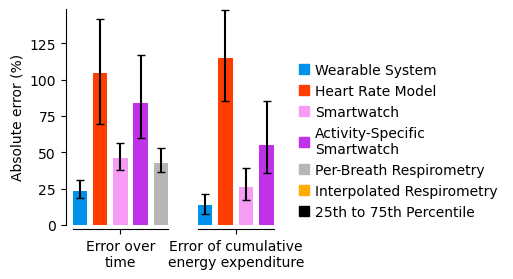

In [10]:
mean_tot_abs_err = np.mean(tot_abs_err_bars,axis=0)
mean_tot_abs_mean = np.mean(tot_abs_mean_bars,axis=0)
mean_tot_cum_err = np.mean(tot_cum_err_bars,axis=0)
mean_tot_cum_mean = np.mean(tot_cum_mean_bars,axis=0)

fig, ax = plt.subplots(1,3,figsize = [plt_third_width*2, plt_height*0.8], gridspec_kw={'width_ratios': [1, 0.8, 1.2]})
y_max = 150
# third figure for bar plot for absolute mean error over time
idx = 0
plt_idx = 0
for i in range(num_plot_vars):
    bar_idx = plot_ord[i]
    ax[plt_idx].bar(idx+i*bar_width+i*bar_spacing, mean_tot_abs_mean[i], bar_width, color=c[bar_idx], yerr=mean_tot_abs_err[i], ecolor='k', capsize=err_capsize)
ax[plt_idx].set_ylabel('Absolute error (%)')
ax[plt_idx].spines['top'].set_color('none')
ax[plt_idx].spines['right'].set_color('none')
ax[plt_idx].spines['bottom'].set_smart_bounds(True)
ax[plt_idx].spines['bottom'].set_position(('axes', axes_spacing_bottom))
ax[plt_idx].spines['left'].set_position(('axes', axes_spacing_left-0.03))
ax[plt_idx].set_xticks([2*bar_width + 2*bar_spacing], minor=False)
ax[plt_idx].set_xticklabels(['Error over\ntime'], minor=False)

#fifth figure for bar plot for absolute mean error
plt_idx = 1
idx = 0
bar_spacing2 = bar_spacing
for i in range(num_plot_vars-1):
    bar_idx = plot_ord[i]
    ax[plt_idx].bar(idx+i*bar_width+i*bar_spacing2, mean_tot_cum_mean[i], bar_width, color=c[bar_idx], yerr=mean_tot_cum_err[i], ecolor='k', capsize=err_capsize)
ax[plt_idx].spines['top'].set_color('none')
ax[plt_idx].spines['right'].set_color('none')
ax[plt_idx].spines['left'].set_color('none')
ax[plt_idx].spines['bottom'].set_smart_bounds(True)
ax[plt_idx].spines['bottom'].set_position(('axes', axes_spacing_bottom))
ax[plt_idx].spines['left'].set_position(('axes', axes_spacing_left))
ax[plt_idx].set_xticks([1.5*bar_width + 1.5*bar_spacing2], minor=False)
ax[plt_idx].set_yticks([], minor=False)
ax[plt_idx].set_xticklabels(['Error of cumulative\nenergy expenditure'], minor=False)
ax[plt_idx].set_ylim(bottom=0,top=y_max)

# plot just for legend
plt_idx = 2
ax[plt_idx].set_xticks([], minor=False)
ax[plt_idx].set_xticklabels([], minor=False)
ax[plt_idx].set_yticks([], minor=False)
ax[plt_idx].set_yticklabels([], minor=False)
ax[plt_idx].spines['top'].set_color('none')
ax[plt_idx].spines['right'].set_color('none')
ax[plt_idx].spines['left'].set_color('none')
ax[plt_idx].spines['bottom'].set_color('none')
ax[plt_idx].set_ylim(bottom=0,top=y_max)

from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color=c[plot_ord[0]]),
                Line2D([0], [0], color=c[plot_ord[1]]),
                Line2D([0], [0], color=c[plot_ord[2]]),
                Line2D([0], [0], color=c[plot_ord[3]]),
                Line2D([0], [0], color=c[plot_ord[4]]),
                Line2D([0], [0], color=orange),
                Line2D([0], [0], color=black)]
plt.rcParams['legend.handlelength'] = 0.0
ax[plt_idx].legend(custom_lines, ["Wearable System","Heart Rate Model","Smartwatch","Activity-Specific\nSmartwatch","Per-Breath Respirometry","Interpolated Respirometry", '25th to 75th Percentile'], loc=(0.0,0.0),frameon=False, handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})
if saving:
    filename = "TV_cum_results"
    plt.savefig(save_dir+filename+".svg", bbox_inches = 'tight', dpi=1200, pad_inches = 0)
    plt.savefig(save_dir+filename+".png", bbox_inches = 'tight', dpi=900, pad_inches = 0)
plt.show()